In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split

# Modelling binomial distribution with GLM (Breast Cancer Data)

In [2]:
breast_cancer_df = pd.read_csv('breast_cancer_data.csv')
# Cleaning
breast_cancer_df['diagnosis_dummy'] = (breast_cancer_df['diagnosis'] == 'M').astype(int)
breast_cancer_df.drop('Unnamed: 32', inplace=True, axis=1)
breast_cancer_df['intercept'] = 1

In [3]:
breast_cancer_df

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,diagnosis_dummy,intercept
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,...,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,1,1
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,...,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,1,1
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,...,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,1,1
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,...,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,1,1
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,...,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,926424,M,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,...,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,1,1
565,926682,M,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,...,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,1,1
566,926954,M,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,...,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,1,1
567,927241,M,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,...,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,1,1


## EDA

([<matplotlib.axis.YTick at 0x24116168880>,
 [Text(0, 0, '0'), Text(0, 1, '1')])

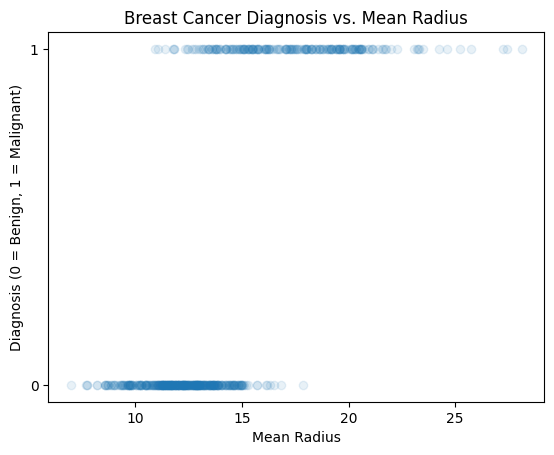

In [4]:
plt.scatter(breast_cancer_df['radius_mean'], breast_cancer_df['diagnosis_dummy'], alpha=0.1)
plt.xlabel('Mean Radius') 
plt.ylabel('Diagnosis (0 = Benign, 1 = Malignant)')  
plt.title('Breast Cancer Diagnosis vs. Mean Radius')
plt.yticks([0, 1])


## Train-test split

In [5]:
breast_cancer_df_train, breast_cancer_df_test = train_test_split(breast_cancer_df, test_size=0.2, random_state=0)

## Implement using sm.GLM() (to check that IWLS is correct)

In [6]:
import statsmodels.api as sm

all_features = list(breast_cancer_df.columns[2:])
all_features.remove('diagnosis_dummy')

x_cols = ['radius_mean']
# all_features = list(df.columns[2:-2])
# x_cols = all_features[:1]
# x_cols = all_features[:30]
x_cols = ['intercept'] + x_cols



model = sm.GLM(breast_cancer_df_train['diagnosis_dummy'], breast_cancer_df_train[x_cols], family=sm.families.Binomial())

result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:        diagnosis_dummy   No. Observations:                  455
Model:                            GLM   Df Residuals:                      453
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -134.40
Date:                Fri, 12 Apr 2024   Deviance:                       268.80
Time:                        15:54:10   Pearson chi2:                     394.
No. Iterations:                     7   Pseudo R-squ. (CS):             0.5128
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept     -14.7120      1.420    -10.364      

In [7]:
beta_from_sm_glm = np.array(list(result.params))

## Implement using iterative WLS

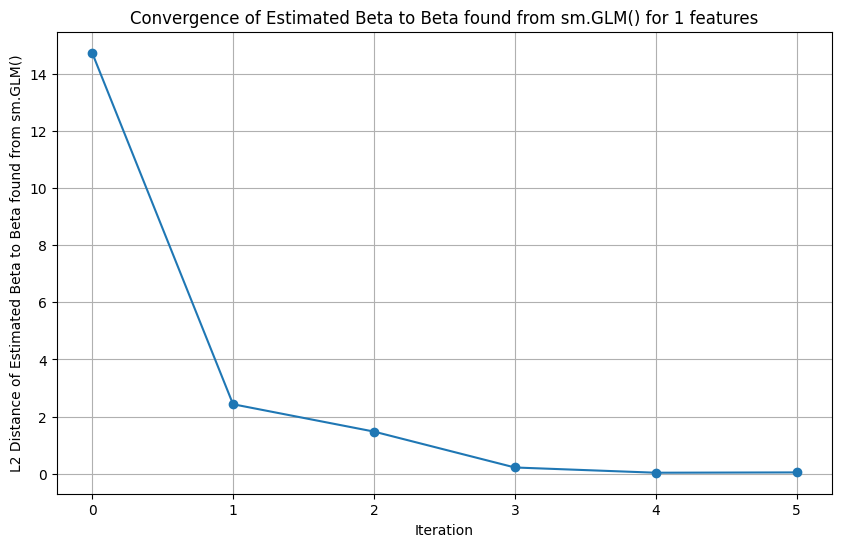

[-14.75452337   0.99404593]
Accuracy: 0.8947368421052632


In [8]:
def logistic_regression_iwls(data, y_col, x_cols, max_iter=10, tol=0.001, ground_truth_beta=None):
    n = len(data)
    
    data = data.copy() 
    # data['intercept'] = 1
    # x_cols = ['intercept'] + x_cols
    
    X = data[x_cols].values
    y = data[y_col].values
    
    # Define the logit link function and its derivative
    def logit(p):
        return np.log(p / (1 - p))
    
    def logit_inv(eta):
        return 1 / (1 + np.exp(-eta))

    def logit_derivative(mu):
        # print(mu)
        return 1/(mu * (1 - mu))
    
    def b_double_derivative(theta):
        return n * (np.exp(theta)) / (1 + np.exp(theta))**2
    
    # Initial estimates for mu and eta using y, but perturb it else we run into numerical issues
    mu = np.where(y == 1, 0.99, 0.01)

    eta = logit(mu)
    theta = np.log(mu /(1-mu))
    
    # Initialize beta estimates
    beta = np.zeros(X.shape[1])

    beta_prev = beta
    
    l2_distances = [np.linalg.norm(beta - ground_truth_beta)]
    for i in range(max_iter):
        # print(f"Beta in iter {i + 1}: {beta}")
        # Update z and weights w
        z = eta + (y - mu) * logit_derivative(mu)
        # w = 1/ (logit_derivative(mu) ** 2 * (mu * (1 - mu)))
        w = 1 / (logit_derivative(mu) ** 2 * b_double_derivative(theta))

        W = np.diag(w)
        
        
        # XTWX = X.T @ W @ X
        # eigenvalues = np.linalg.eigvals(XTWX)
        # min_eigenvalue = np.min(eigenvalues)
        # max_eigenvalue = np.max(eigenvalues)
        # print(f"Iter {i}: Min eigenvalue of XTWX: {min_eigenvalue}, Max eignevalue of XTWX: {max_eigenvalue}")

        
        
        XTWX_inv = np.linalg.inv(X.T @ W @ X)
        XTWZ = X.T @ W @ z
        beta = XTWX_inv @ XTWZ
        
        if np.max(np.abs(beta - beta_prev)) < tol:
            break


        eta = X @ beta
        mu = logit_inv(eta)
        
        l2_distance = np.linalg.norm(beta - ground_truth_beta)
        l2_distances.append(l2_distance)

        has_nan = np.any(np.isnan(beta))
        if has_nan:
            beta = beta_prev
            l2_distances.pop()
            break
            print(beta_prev)
            return beta_prev

        beta_prev = beta
        
    if ground_truth_beta is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(l2_distances, marker='o')
        plt.xlabel('Iteration')
        plt.ylabel('L2 Distance of Estimated Beta to Beta found from sm.GLM()')
        plt.title(f'Convergence of Estimated Beta to Beta found from sm.GLM() for {len(x_cols) - 1} features')
        plt.xticks(np.arange(0, len(l2_distances), step=1))  
        plt.grid(True)
        plt.show()
    print(beta)    
    return beta

def predict(data, params, x_cols):
    data = data.copy()  # Make a copy to avoid modifying the original DataFrame
    X = data[x_cols].values
    linear_prediction = np.dot(X, params)
    pred_prob = 1 / (1 + np.exp(-linear_prediction))
    return pred_prob

# x_cols = all_features[:10] + ['intercept']
# x_cols = all_features
params = logistic_regression_iwls(breast_cancer_df_train, 'diagnosis_dummy', x_cols, tol=0.001, max_iter=10000, ground_truth_beta=beta_from_sm_glm)

# Predict on test set
breast_cancer_df_test['pred_prob_glm'] = predict(breast_cancer_df_test, params, x_cols)

# Calculate accuracy
breast_cancer_df_test['predicted_diagnosis'] = (breast_cancer_df_test['pred_prob_glm'] > 0.5).astype(int)
accuracy_with_log_glm = (breast_cancer_df_test['predicted_diagnosis'] == breast_cancer_df_test['diagnosis_dummy']).mean()
print(f"Accuracy: {accuracy_with_log_glm}")

## Illustration of Results

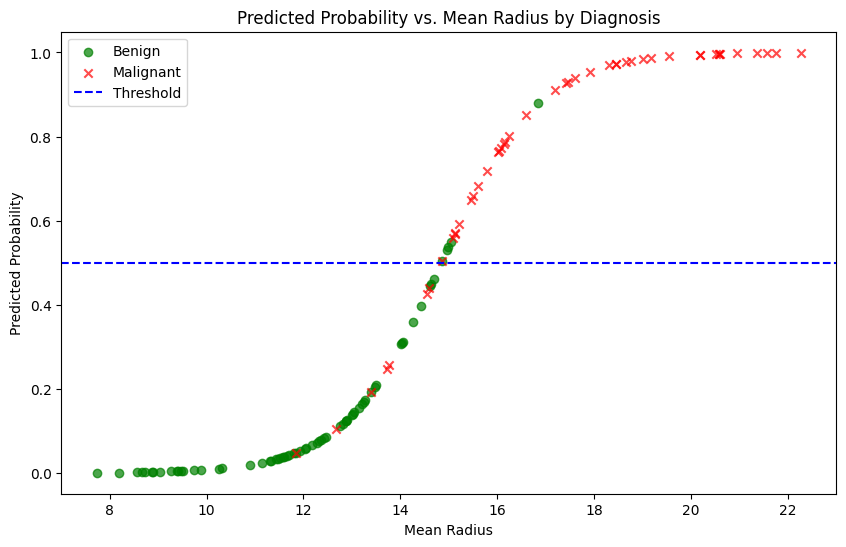

Accuracy using Logistic GLM: 0.8947368421052632


In [9]:
import matplotlib.pyplot as plt

benign = breast_cancer_df_test[breast_cancer_df_test['diagnosis_dummy'] == 0]
malignant = breast_cancer_df_test[breast_cancer_df_test['diagnosis_dummy'] == 1]

plt.figure(figsize=(10, 6))

plt.scatter(benign['radius_mean'], benign['pred_prob_glm'], color='green', marker='o', alpha=0.7, label='Benign')

plt.scatter(malignant['radius_mean'], malignant['pred_prob_glm'], color='red', marker='x', alpha=0.7, label='Malignant')

plt.axhline(y=0.5, color='blue', linestyle='--', label='Threshold')

plt.title('Predicted Probability vs. Mean Radius by Diagnosis')
plt.xlabel('Mean Radius')
plt.ylabel('Predicted Probability')
plt.legend()
plt.show()

print(f"Accuracy using Logistic GLM: {accuracy_with_log_glm}")

## Using OLS to predict breast cancer

In [10]:
import statsmodels.formula.api as smf

model = smf.ols(formula='diagnosis_dummy ~ radius_mean', data=breast_cancer_df_train).fit()

print(model.summary())

breast_cancer_df_test['pred_prob_ols'] = model.predict(breast_cancer_df_test[['radius_mean']])

# Threshold the predicted values to get binary outcomes
breast_cancer_df_test['predicted_diagnosis_ols'] = (breast_cancer_df_test['pred_prob_ols'] > 0.5).astype(int)

accuracy_with_ols = (breast_cancer_df_test['predicted_diagnosis_ols'] == breast_cancer_df_test['diagnosis_dummy']).mean()

print(f"Model accuracy on test set: {accuracy_with_ols}")


                            OLS Regression Results                            
Dep. Variable:        diagnosis_dummy   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.524
Method:                 Least Squares   F-statistic:                     500.0
Date:                Fri, 12 Apr 2024   Prob (F-statistic):           3.62e-75
Time:                        15:54:11   Log-Likelihood:                -143.19
No. Observations:                 455   AIC:                             290.4
Df Residuals:                     453   BIC:                             298.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.0289      0.064    -16.038      

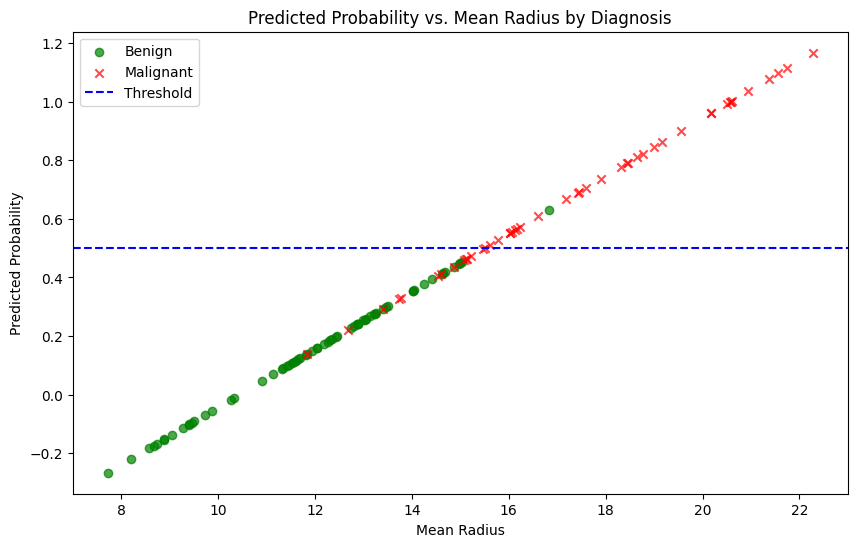

Accuracy using OLS: 0.868421052631579


In [11]:
import matplotlib.pyplot as plt

benign = breast_cancer_df_test[breast_cancer_df_test['diagnosis_dummy'] == 0]
malignant = breast_cancer_df_test[breast_cancer_df_test['diagnosis_dummy'] == 1]

plt.figure(figsize=(10, 6))

plt.scatter(benign['radius_mean'], benign['pred_prob_ols'], color='green', marker='o', alpha=0.7, label='Benign')

plt.scatter(malignant['radius_mean'], malignant['pred_prob_ols'], color='red', marker='x', alpha=0.7, label='Malignant')

plt.axhline(y=0.5, color='blue', linestyle='--', label='Threshold')

plt.title('Predicted Probability vs. Mean Radius by Diagnosis')
plt.xlabel('Mean Radius')
plt.ylabel('Predicted Probability')
plt.legend()
plt.show()

print(f"Accuracy using OLS: {accuracy_with_ols}")

# Modelling Poisson Distribution with GLM (Simulated Data)

In [12]:
np.random.seed(0)

n_samples = 10000
n_features = 2

X = np.random.uniform(-1, 1, (n_samples, n_features))

beta = np.linspace(2, 4, n_features)

lambda_ = np.exp(np.dot(X, beta))
y = np.random.poisson(lambda_)

features = {f'feat{i+1}': X[:, i] for i in range(n_features)}
poisson_df = pd.DataFrame({'target': y, **features})

poisson_df.head()

,target,feat1,feat2
0,9,0.097627,0.430379
1,3,0.205527,0.089766
2,0,-0.152690,0.291788
3,18,-0.124826,0.783546
4,3,0.927326,-0.233117


In [13]:
print(f"Ground truth beta: {beta}")

Ground truth beta: [2. 4.]


## Train test split

In [14]:
poisson_df_train, poisson_df_test = train_test_split(poisson_df, test_size=0.2, random_state=0)

## Implement using IWLS

['feat1', 'feat2']


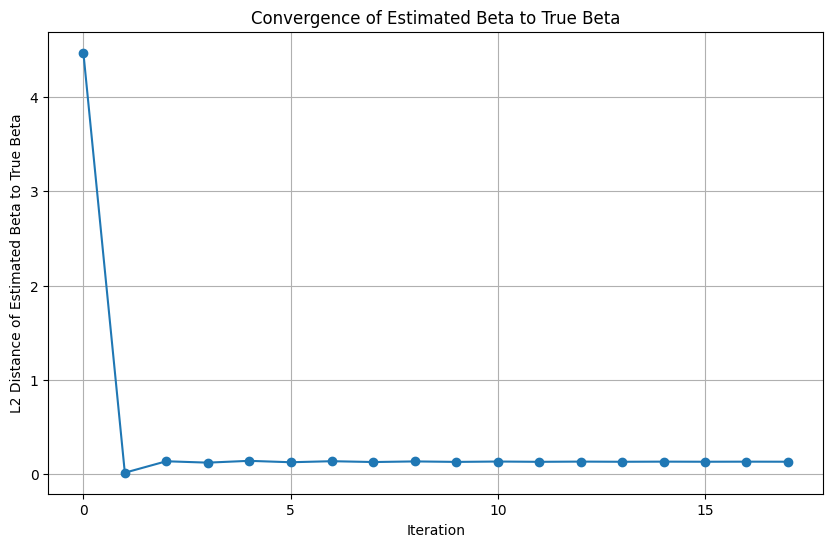

[1.97392532 3.87268383]


In [15]:
import numpy as np

def poisson_glm(data, y_col, x_cols, max_iter=10, tol=0.001, ground_truth_beta=None):
    n = len(data)
    
    data = data.copy()
    X = data[x_cols].values
    y = data[y_col].values
    
    def log_deriv(mu):
        return 1/mu
    
    mu = y + 0.01  # Adding 0.1 to avoid log(0) for initial estimation
    eta = np.log(mu)
    
    # Initialize beta estimates
    beta = np.zeros(X.shape[1])
    theta = np.log(mu)
    prev_beta = beta
    
    l2_distances = [np.linalg.norm(beta - ground_truth_beta)]

    for _ in range(max_iter):
        # print(f"Beta in iter {_ + 1}: {beta}")
        z = eta + (y - mu) * log_deriv(mu)
        w = 1 / (log_deriv(mu) ** 2 * np.exp(theta))
        
        W = np.diag(w)
        
        XTWX_inv = np.linalg.inv(X.T @ W @ X)
        XTWZ = X.T @ W @ z
        beta = XTWX_inv @ XTWZ

        eta = X @ beta
        mu = np.exp(eta)
        
        if np.max(np.abs(beta - prev_beta)) < tol:
            break
        prev_beta = beta
        l2_distance = np.linalg.norm(beta - ground_truth_beta)
        l2_distances.append(l2_distance)
        
    if ground_truth_beta is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(l2_distances, marker='o')
        plt.xlabel('Iteration')
        plt.ylabel('L2 Distance of Estimated Beta to True Beta')
        plt.title('Convergence of Estimated Beta to True Beta')
        plt.xticks(np.arange(0, len(l2_distances), step=5))  
        plt.grid(True)
        plt.show()
    
    return beta

def predict(data, params, x_cols):
    data = data.copy()  # Make a copy to avoid modifying the original DataFrame
    X = data[x_cols].values
    linear_prediction = np.dot(X, params)
    pred_count = np.exp(linear_prediction)  # Use exp since it's the inverse of the log link
    return pred_count

y_col = (poisson_df_train.columns[0])
x_cols = list(poisson_df_train.columns[1:])
x_cols = [f'feat{i}' for i in range(1, 1 + n_features)]
print(x_cols)
params = poisson_glm(poisson_df_train, y_col, x_cols, max_iter=50, tol=0.001, ground_truth_beta=np.array([2,4]))
print(params)
poisson_df_train['predicted_counts'] = predict(poisson_df_train, params, x_cols)

## Implement using sm.GLM()

In [16]:
# y_col = (poisson_df_train.columns[0])
# x_cols = list(poisson_df_train.columns[1:])
# x_cols=['feat1']
model = sm.GLM(poisson_df_train[y_col], poisson_df_train[x_cols], family=sm.families.Poisson())

# Fit the model
result = model.fit()

# Print the fitted parameters
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                 8000
Model:                            GLM   Df Residuals:                     7998
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -11705.
Date:                Fri, 12 Apr 2024   Deviance:                       6520.6
Time:                        15:54:20   Pearson chi2:                 8.10e+03
No. Iterations:                     6   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
feat1          2.0026      0.007    283.346      0.0

In [17]:
X_test, y_test = poisson_df_test[x_cols], poisson_df_test[y_col]
predictions = result.predict(X_test)
mae = np.mean(np.abs((y_test - predictions) ))
print(f"MAE with Poisson GLM: {mae}")

MAE with Poisson GLM: 1.698216867992496


## Scatter plot

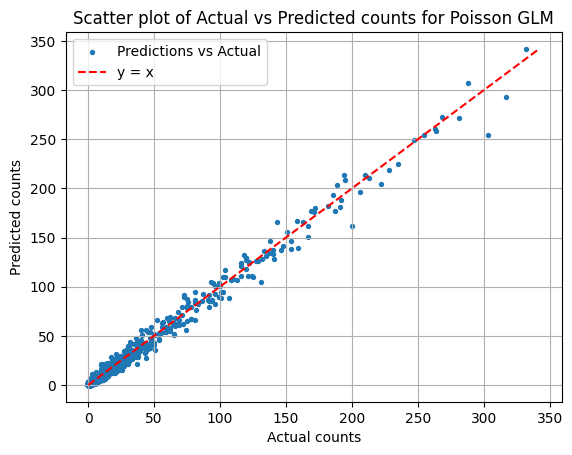

In [18]:
import matplotlib.pyplot as plt
plt.scatter(poisson_df_test['target'], predictions, label='Predictions vs Actual', s=8)

max_val = max(poisson_df_test['target'].max(), predictions.max())
min_val = min(poisson_df_test['target'].min(), predictions.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x') 

plt.xlabel('Actual counts')
plt.ylabel('Predicted counts')
plt.title('Scatter plot of Actual vs Predicted counts for Poisson GLM')
plt.legend()
plt.grid(True)
plt.show()

## Implement using OLS

In [19]:
formula_with_intercept = 'target ~ feat1 + feat2'
ols_model_with_intercept = smf.ols(formula=formula_with_intercept, data=poisson_df_train)
ols_result_with_intercept = ols_model_with_intercept.fit()

poisson_df_test['intercept'] = 1
ols_predictions_with_intercept = ols_result_with_intercept.predict(poisson_df_test[['intercept', 'feat1', 'feat2']])
ols_mae_with_intercept = np.mean(np.abs((y_test - ols_predictions_with_intercept)))

print(ols_result_with_intercept.summary())
print(f"MAE with OLS: {ols_mae_with_intercept}")

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.349
Method:                 Least Squares   F-statistic:                     2146.
Date:                Fri, 12 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:54:20   Log-Likelihood:                -37557.
No. Observations:                8000   AIC:                         7.512e+04
Df Residuals:                    7997   BIC:                         7.514e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.4702      0.296     42.130      0.0

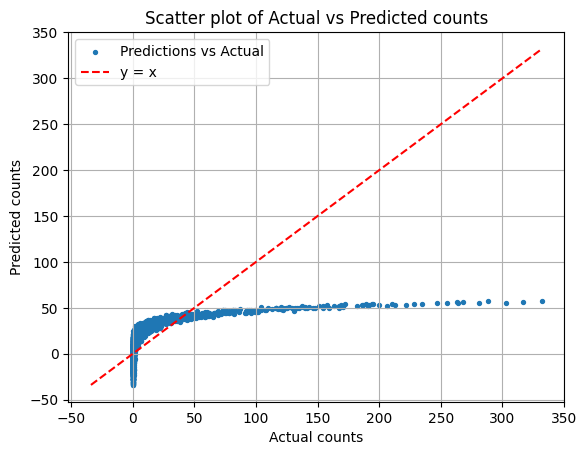

In [20]:
import matplotlib.pyplot as plt

plt.scatter(poisson_df_test['target'], ols_predictions_with_intercept, label='Predictions vs Actual', s=8)

max_val = max(poisson_df_test['target'].max(), ols_predictions_with_intercept.max())
min_val = min(poisson_df_test['target'].min(), ols_predictions_with_intercept.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='y = x')  

plt.xlabel('Actual counts')
plt.ylabel('Predicted counts')
plt.title('Scatter plot of Actual vs Predicted counts')
plt.legend()
plt.grid(True)
plt.show()
